<a href="https://colab.research.google.com/github/hari-599/Deep-style-neural-Transfer/blob/main/DL_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


## Task 2 : Loading VGG Pretrained Model

In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
print(device)

cuda


## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [18]:
from PIL import Image


In [24]:
  def load_image(img_path, max_size=400, shape=None):
    image=Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image


In [25]:
content=load_image('/content/Project-NST/spiderman.jpg').to(device)
style=load_image('/content/Project-NST/style11.jpg').to(device)
print(content.shape)
print(style.shape)

torch.Size([1, 3, 400, 711])
torch.Size([1, 3, 400, 462])


## Task 4 : Deprocess image

In [26]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

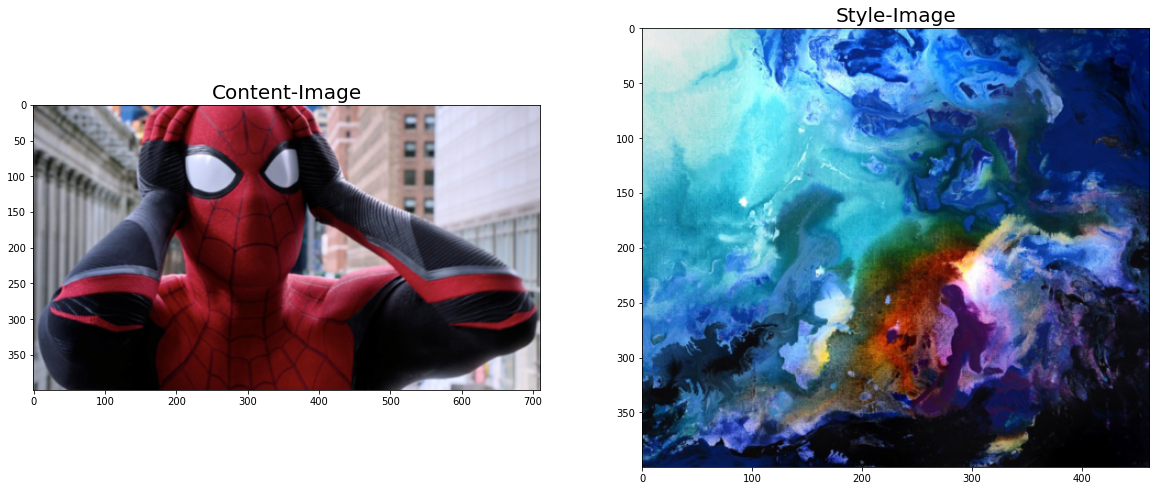

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content-Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style-Image", fontsize = 20)
plt.show()

## Task 5 : Get content,style features and create gram matrix

In [43]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2', #content
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [44]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

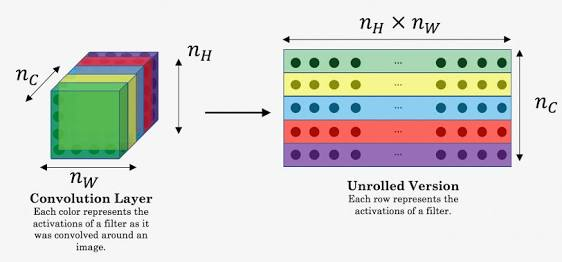

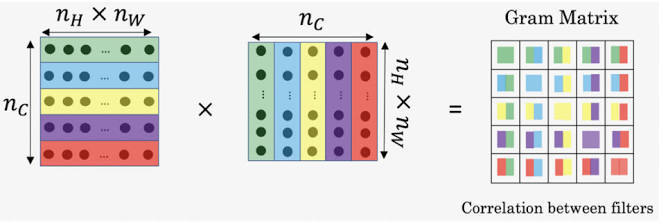

In [45]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

## Task 6 : Creating Style and Content loss function

In [46]:
style_weights = {'conv1_1': 1.5,
                 'conv2_1': 0.80,
                 'conv3_1': 0.25,
                 'conv4_1': 0.25,
                 'conv5_1': 0.25}

content_weight = 1e-2  
style_weight = 1e9  

## Task 7 : Training loop

Total loss:  5473836032.0


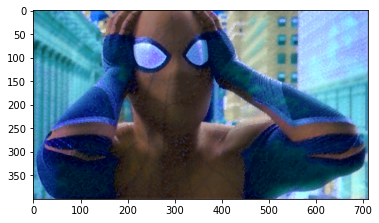

Total loss:  3331960064.0


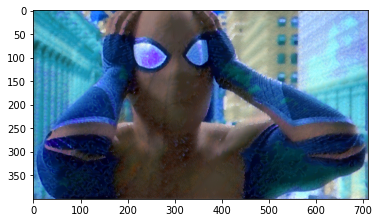

Total loss:  2809736704.0


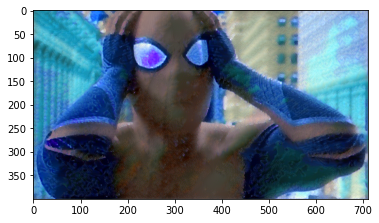

Total loss:  2553459456.0


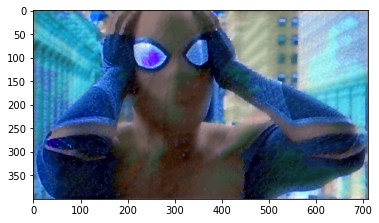

Total loss:  2390387712.0


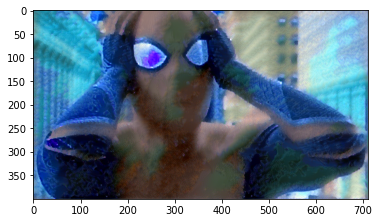

Total loss:  2280671488.0


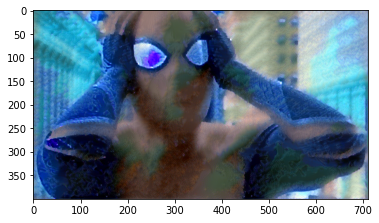

Total loss:  2202368256.0


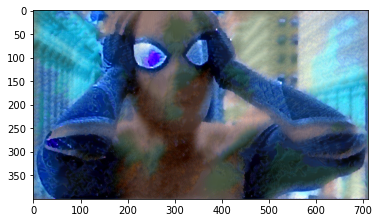

Total loss:  2142459648.0


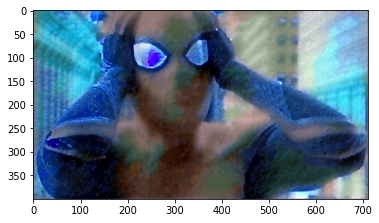

Total loss:  2095663744.0


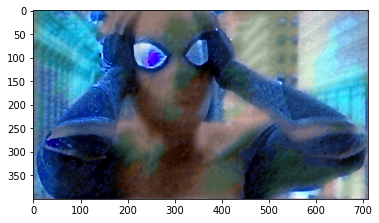

Total loss:  2058472192.0


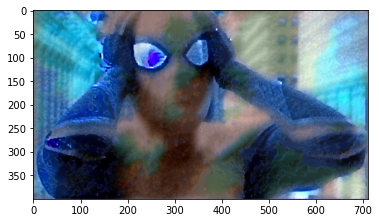

Total loss:  2027777408.0


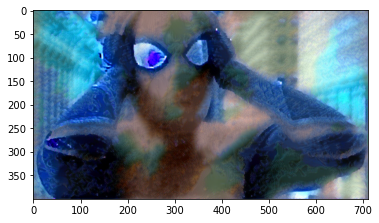

Total loss:  2007568128.0


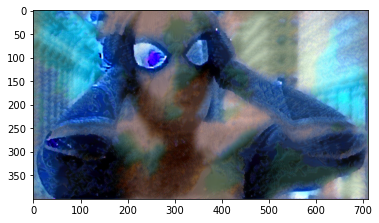

Total loss:  1988692224.0


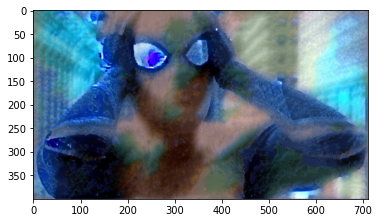

Total loss:  1976159104.0


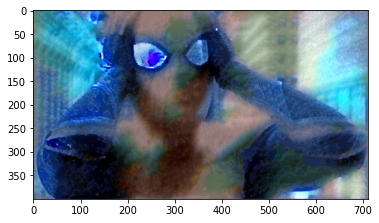

Total loss:  1960258560.0


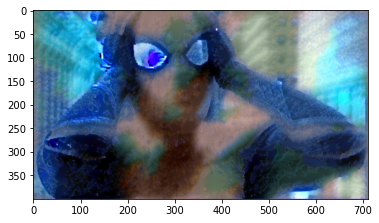

Total loss:  1951145600.0


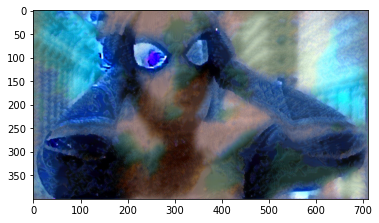

Total loss:  1941603456.0


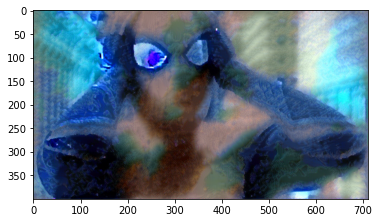

In [48]:
show = 400

optimizer = optim.Adam([target], lr=0.01)
steps = 7000  

for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

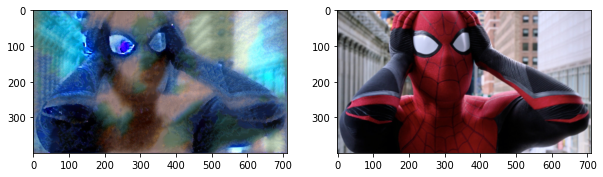

In [49]:
target_copy=im_convert(target.detach())
content_copy=im_convert(content)
fig,(ax1,ax2) =plt.subplots(1,2, figsize=(10,8))
ax1.imshow(target_copy)
ax2.imshow(content_copy)